# MC - Variance Reduction Technique
Simple code to show MC with Impontant Sampling for European Options

In [2]:
import numpy as np

class MonteCarloEngine:
    """Monte Carlo engine for simulating Brownian paths."""

    def __init__(self, T: float, n_paths: int, n_steps: int, rng: np.random.Generator) -> None:
        self.T = T
        self.n_paths = n_paths
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.sqrt_dt = np.sqrt(self.dt)
        self.rng = rng
        self.time_grid = np.linspace(0.0, T, n_steps + 1)

    def generate_brownian_increments(self) -> np.ndarray:
        """
        Generate standard Brownian motion increments dW for all paths and steps.
        Each path i has a sequence of random increments over time steps j:

            dW =
                   step_1   step_2   ...  step_N
            path_1   x11      x12    ...   x1N
            path_2   x21      x22    ...   x2N
            ...      ...      ...    ...   ...
            path_M   xM1      xM2    ...   xMN

        Each element x_ij represents one Brownian increment:
            dW_t = N(0,1) * sqrt(dt)

        Returns: array of shape (n_paths, n_steps)
        """
        dW = self.rng.standard_normal((self.n_paths, self.n_steps)) * self.sqrt_dt
        return dW

    def generate_brownian_paths(self) -> np.ndarray:
            """
            Generate Brownian motion paths W_t by cumulatively summing the increments dW.

            Each path i accumulates its increments over time steps j:

                dW =
                       step_1   step_2   ...  step_N
                path_1   x11      x12    ...   x1N
                path_2   x21      x22    ...   x2N
                ...      ...      ...    ...   ...
                path_M   xM1      xM2    ...   xMN

            The Brownian motion W_t is built as the cumulative sum of these increments.
            Including W_0 = 0

                W =
                        t0     t1       t2      ...    tN
                path_1   0    x11     x11+x12   ...   Sum x1j
                path_2   0    x21     x21+x22   ...   Sum x2j
                ...      ...    ...      ...    ...    ...
                path_M   0    xM1     xM1+xM2   ...   Sum xMj

            Mathematically:
                W_t = Sum_{k=1}^{t/dt} (N(0,1) * sqrt(dt))

            Returns: array of shape (n_paths, n_steps + 1)
            """
            dW = self.generate_brownian_increments()
            W = np.zeros((self.n_paths, self.n_steps + 1))
            W[:, 1:] = np.cumsum(dW, axis=1)
            return W

    def generate_gbm_paths(self, S0: float, r: float, q: float, sigma: float) -> np.ndarray:
        """Generate GBM paths using exact discretization."""
        W = self.generate_brownian_paths()
        drift = (r - q - 0.5 * sigma**2) * self.time_grid
        diffusion = sigma * W
        S = S0 * np.exp(drift[None, :] + diffusion)
        return S

Important Sampling vs Quasi Montecarlo

In [13]:
from matplotlib.pylab import Generator
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm
from typing import Tuple

# -------------------------------------------------
#  Monte Carlo
# -------------------------------------------------
def european_call_mc(
        s0: float,
        K: float,
        r: float,
        q: float,
        sigma: float,
        T: float,
        paths: int,
        seed: int = 0) -> Tuple[float, np.ndarray]:
    """ European call with MC simulations. """
    rng = np.random.default_rng(seed)
    engine = MonteCarloEngine(T=T, n_paths=paths, n_steps=1, rng=rng)

    # Generate both bumps using the same Brownian motion
    # Take Terminal Value!
    ST = engine.generate_gbm_paths(S0=s0, r=r, q=q, sigma=sigma)[:,1]
    payoff = np.maximum(ST - K, 0.0)
    price = np.exp(-r * T) * payoff.mean()
    return price , payoff

# -------------------------------------------------
#  Monte Carlo (Important Sampling)
# -------------------------------------------------
def european_call_mc_is(
        s0: float,
        K: float,
        r: float,
        q: float,
        sigma: float,
        T: float,
        paths: int,
        mu_shift: float,
        seed: int = 0) -> Tuple[float, np.ndarray, np.ndarray]:
    """European call with Importance Sampling (mean-shifted normal)."""
    rng: Generator = np.random.default_rng(seed)
    
    # Draw shifted normals: Z' = Z + mu_shift
    Z = rng.standard_normal(size=paths)
    Z_shifted = Z + mu_shift

    # Likelihood ratio w(Z') = exp(-mu*Z' + 0.5*mu^2)
    weights = np.exp(-mu_shift * Z_shifted + 0.5 * mu_shift**2)

    # Compute terminal prices S_T using shifted Brownian motion
    ST = s0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_shifted)

    # Weighted discounted payoff
    discounted_payoff = np.exp(-r * T) * np.maximum(ST - K, 0.0) * weights

    # Present value
    price = discounted_payoff.mean()

    return price, discounted_payoff, weights

# -------------------------------------------------
#  Quasi–Monte Carlo (Sobol)
# -------------------------------------------------
def european_call_mc_qmc(
        s0: float,
        K: float,
        r: float,
        q: float,
        sigma: float,
        T: float,
        paths: int,
        scramble: bool = True,
        seed: int | None = None) -> Tuple[float, np.ndarray]:
    """European call with Quasi Monte Carlo using Sobol sequence."""

    # Control reproducibility for scrambled Sobol
    if scramble and seed is not None:
        np.random.seed(seed)

    sampler = qmc.Sobol(d=1, scramble=scramble)
    u = sampler.random(paths).flatten()

    # Convert uniform samples to standard normal via inverse CDF
    Z = norm.ppf(u)

    # Generate GBM terminal values directly
    ST = s0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0.0)
    price = np.exp(-r * T) * payoff.mean()
    return price, payoff

In [14]:
# Parameters for Option

# Option details
K, r, q, sigma, T = 100, 0.05, 0.0, 0.2, 1.0

s0_otm = 50
s0_atm = 100
s0_itm = 110

# Run multiple seeds to see variability
n_runs: int = 100

mu_shift = 1

/var/folders/_v/hpmnm2gj4x9ftq5l566y0m6c0000gn/T/ipykernel_51897/3853189781.py:84: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(paths).flatten()


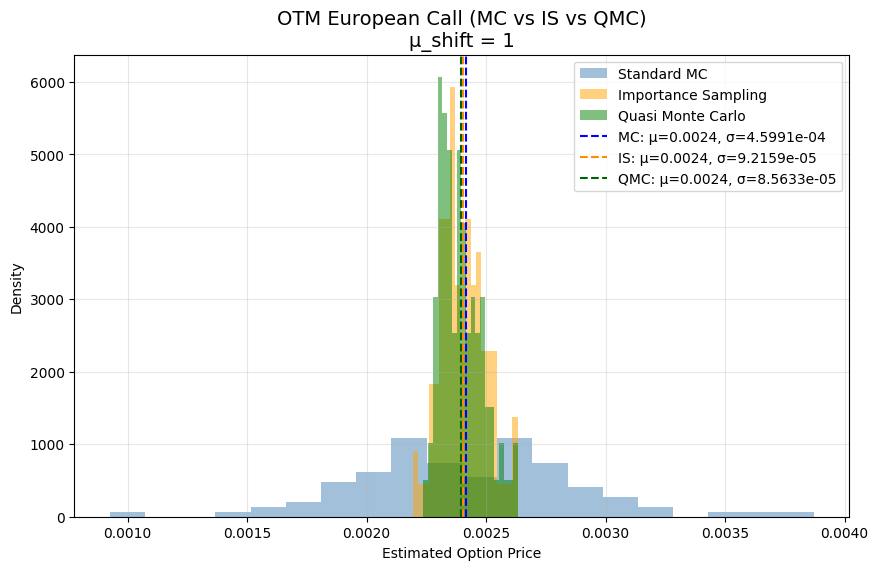

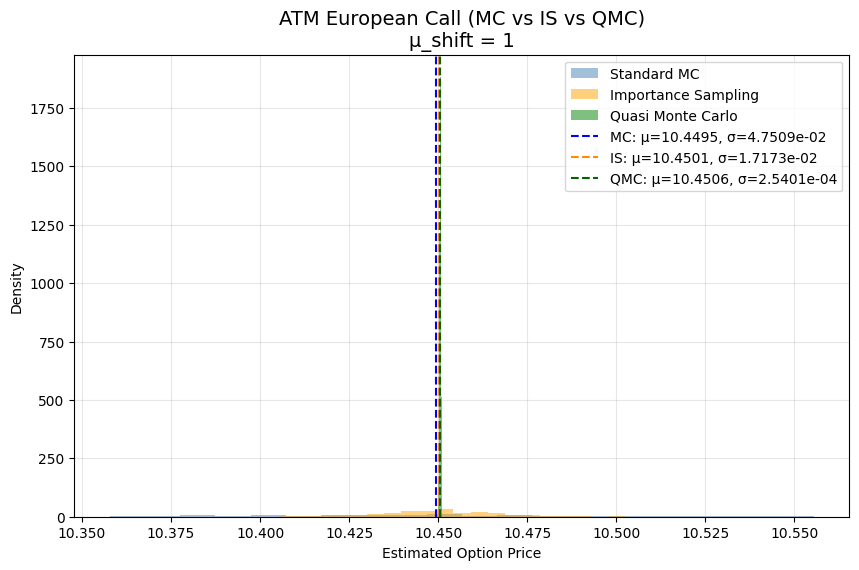

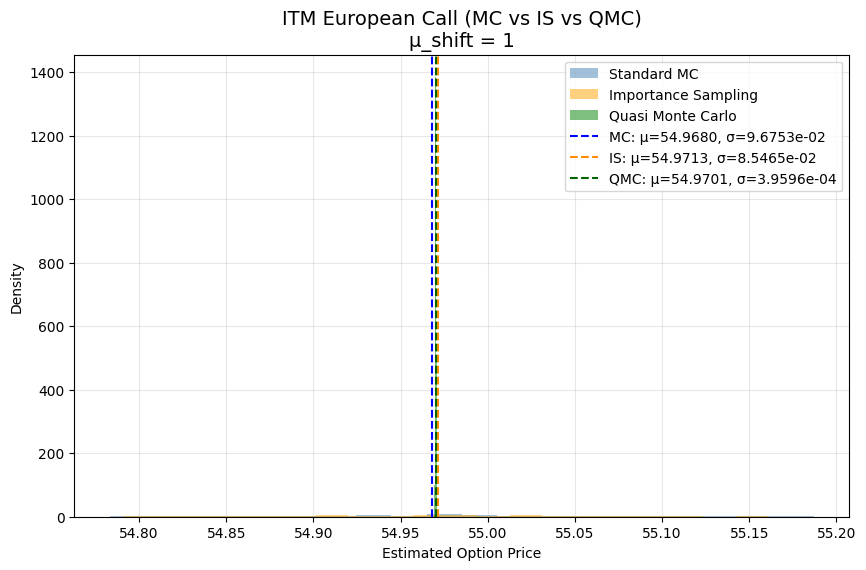

In [18]:
# --- Parameters ---
K, r, q, sigma, T = 100, 0.05, 0.0, 0.2, 1.0
s0_otm, s0_atm, s0_itm = 50, 100, 150
n_paths, n_runs, mu_shift = 100_000, 100, 1

# --- Containers for results ---
mc_estimates_otm, mc_is_estimates_otm, mc_qmc_estimates_otm = [], [], []
mc_estimates_atm, mc_is_estimates_atm, mc_qmc_estimates_atm = [], [], []
mc_estimates_itm, mc_is_estimates_itm, mc_qmc_estimates_itm = [], [], []

# --- Run all seeds ---
for seed in range(n_runs):
    # --- OTM ---
    mc_estimates_otm.append(european_call_mc(s0_otm, K, r, q, sigma, T, n_paths, seed)[0])
    mc_is_estimates_otm.append(european_call_mc_is(s0_otm, K, r, q, sigma, T, n_paths, mu_shift, seed)[0])
    mc_qmc_estimates_otm.append(european_call_mc_qmc(s0_otm, K, r, q, sigma, T, n_paths, scramble=True, seed=seed)[0])

    # --- ATM ---
    mc_estimates_atm.append(european_call_mc(s0_atm, K, r, q, sigma, T, n_paths, seed)[0])
    mc_is_estimates_atm.append(european_call_mc_is(s0_atm, K, r, q, sigma, T, n_paths, mu_shift, seed)[0])
    mc_qmc_estimates_atm.append(european_call_mc_qmc(s0_atm, K, r, q, sigma, T, n_paths, scramble=True, seed=seed)[0])

    # --- ITM ---
    mc_estimates_itm.append(european_call_mc(s0_itm, K, r, q, sigma, T, n_paths, seed)[0])
    mc_is_estimates_itm.append(european_call_mc_is(s0_itm, K, r, q, sigma, T, n_paths, mu_shift, seed)[0])
    mc_qmc_estimates_itm.append(european_call_mc_qmc(s0_itm, K, r, q, sigma, T, n_paths, scramble=True, seed=seed)[0])

# --- Convert to arrays ---
def arr(x): return np.array(x)
mc_estimates_otm, mc_is_estimates_otm, mc_qmc_estimates_otm = map(arr, [mc_estimates_otm, mc_is_estimates_otm, mc_qmc_estimates_otm])
mc_estimates_atm, mc_is_estimates_atm, mc_qmc_estimates_atm = map(arr, [mc_estimates_atm, mc_is_estimates_atm, mc_qmc_estimates_atm])
mc_estimates_itm, mc_is_estimates_itm, mc_qmc_estimates_itm = map(arr, [mc_estimates_itm, mc_is_estimates_itm, mc_qmc_estimates_itm])

# --- Helper to plot ---
def plot_distribution(mc, is_mc, qmc, title):
    plt.figure(figsize=(10, 6))
    plt.hist(mc, bins=20, alpha=0.5, density=True, label="Standard MC", color="steelblue")
    plt.hist(is_mc, bins=20, alpha=0.5, density=True, label="Importance Sampling", color="orange")
    plt.hist(qmc, bins=20, alpha=0.5, density=True, label="Quasi Monte Carlo", color="green")

    # Compute means and stds
    mean_mc, mean_is, mean_qmc = np.mean(mc), np.mean(is_mc), np.mean(qmc)
    std_mc, std_is, std_qmc = np.std(mc), np.std(is_mc), np.std(qmc)

    # Vertical lines for means
    plt.axvline(mean_mc, color="blue", ls="--",
                label=f"MC: μ={mean_mc:.4f}, σ={std_mc:.4e}")
    plt.axvline(mean_is, color="darkorange", ls="--",
                label=f"IS: μ={mean_is:.4f}, σ={std_is:.4e}")
    plt.axvline(mean_qmc, color="darkgreen", ls="--",
                label=f"QMC: μ={mean_qmc:.4f}, σ={std_qmc:.4e}")

    plt.title(f"{title}\nμ_shift = {mu_shift}", fontsize=14)
    plt.xlabel("Estimated Option Price")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# --- Plot all three moneyness levels ---
plot_distribution(mc_estimates_otm, mc_is_estimates_otm, mc_qmc_estimates_otm, "OTM European Call (MC vs IS vs QMC)")
plot_distribution(mc_estimates_atm, mc_is_estimates_atm, mc_qmc_estimates_atm, "ATM European Call (MC vs IS vs QMC)")
plot_distribution(mc_estimates_itm, mc_is_estimates_itm, mc_qmc_estimates_itm, "ITM European Call (MC vs IS vs QMC)")


/var/folders/_v/hpmnm2gj4x9ftq5l566y0m6c0000gn/T/ipykernel_51897/3853189781.py:84: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = sampler.random(paths).flatten()


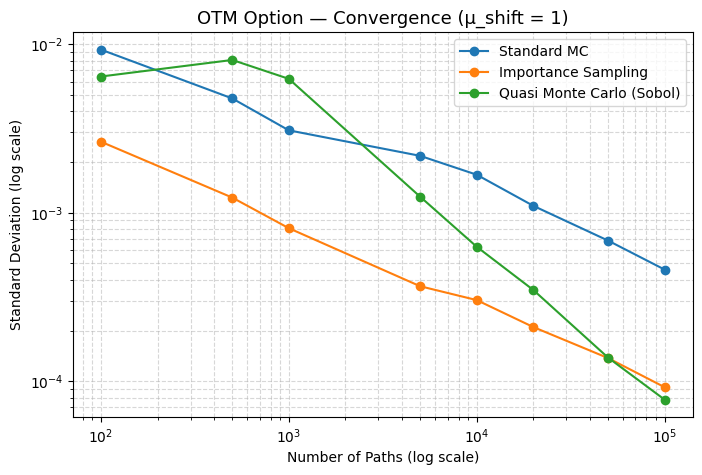

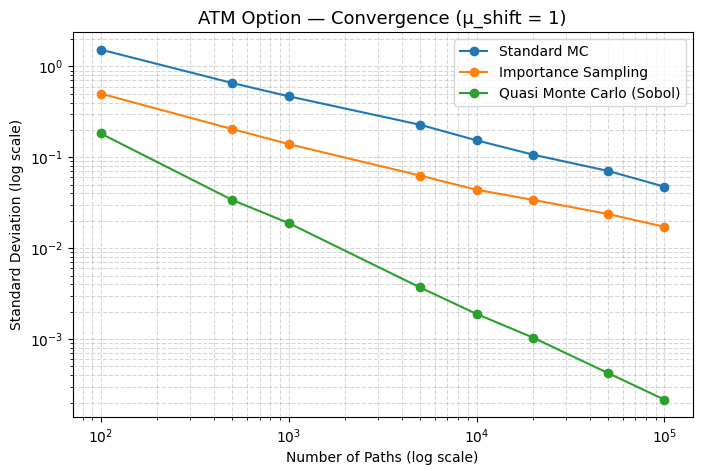

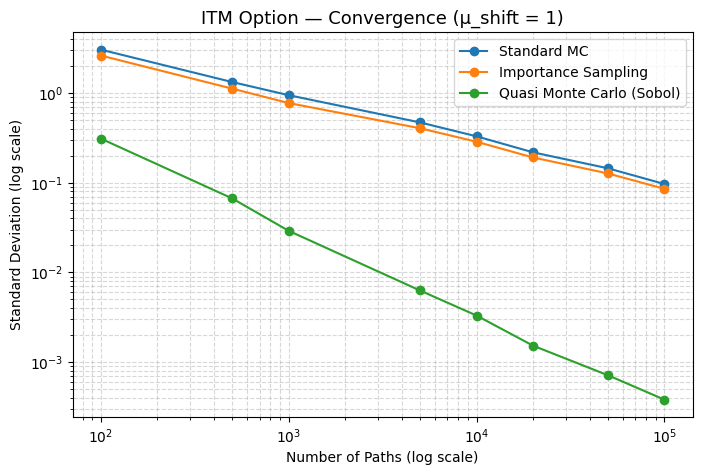

In [17]:
# --- Path grid ---
path_list = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000]

# --- Store stds for each method and moneyness ---
mc_std_otm, mc_is_std_otm, mc_qmc_std_otm = [], [], []
mc_std_atm, mc_is_std_atm, mc_qmc_std_atm = [], [], []
mc_std_itm, mc_is_std_itm, mc_qmc_std_itm = [], [], []

# --- Loop across path sizes ---
for n_paths in path_list:
    seeds = np.arange(n_runs)

    # --- OTM ---
    mc_estimates_otm, mc_is_estimates_otm, mc_qmc_estimates_otm = [], [], []
    for seed in seeds:
        mc_estimates_otm.append(european_call_mc(s0_otm, K, r, q, sigma, T, n_paths, seed)[0])
        mc_is_estimates_otm.append(european_call_mc_is(s0_otm, K, r, q, sigma, T, n_paths, mu_shift, seed)[0])
        mc_qmc_estimates_otm.append(european_call_mc_qmc(s0_otm, K, r, q, sigma, T, n_paths, scramble=True, seed=seed)[0])
    mc_std_otm.append(np.std(mc_estimates_otm))
    mc_is_std_otm.append(np.std(mc_is_estimates_otm))
    mc_qmc_std_otm.append(np.std(mc_qmc_estimates_otm))

    # --- ATM ---
    mc_estimates_atm, mc_is_estimates_atm, mc_qmc_estimates_atm = [], [], []
    for seed in seeds:
        mc_estimates_atm.append(european_call_mc(s0_atm, K, r, q, sigma, T, n_paths, seed)[0])
        mc_is_estimates_atm.append(european_call_mc_is(s0_atm, K, r, q, sigma, T, n_paths, mu_shift, seed)[0])
        mc_qmc_estimates_atm.append(european_call_mc_qmc(s0_atm, K, r, q, sigma, T, n_paths, scramble=True, seed=seed)[0])
    mc_std_atm.append(np.std(mc_estimates_atm))
    mc_is_std_atm.append(np.std(mc_is_estimates_atm))
    mc_qmc_std_atm.append(np.std(mc_qmc_estimates_atm))

    # --- ITM ---
    mc_estimates_itm, mc_is_estimates_itm, mc_qmc_estimates_itm = [], [], []
    for seed in seeds:
        mc_estimates_itm.append(european_call_mc(s0_itm, K, r, q, sigma, T, n_paths, seed)[0])
        mc_is_estimates_itm.append(european_call_mc_is(s0_itm, K, r, q, sigma, T, n_paths, mu_shift, seed)[0])
        mc_qmc_estimates_itm.append(european_call_mc_qmc(s0_itm, K, r, q, sigma, T, n_paths, scramble=True, seed=seed)[0])
    mc_std_itm.append(np.std(mc_estimates_itm))
    mc_is_std_itm.append(np.std(mc_is_estimates_itm))
    mc_qmc_std_itm.append(np.std(mc_qmc_estimates_itm))

# --- Helper for plotting ---
def plot_distribution(mc, is_mc, qmc, title):
    plt.figure(figsize=(10, 6))
    plt.hist(mc, bins=20, alpha=0.5, density=True, label="Standard MC", color="steelblue")
    plt.hist(is_mc, bins=20, alpha=0.5, density=True, label="Importance Sampling", color="orange")
    plt.hist(qmc, bins=20, alpha=0.5, density=True, label="Quasi Monte Carlo", color="green")

    # Compute means and stds
    mean_mc, mean_is, mean_qmc = np.mean(mc), np.mean(is_mc), np.mean(qmc)
    std_mc, std_is, std_qmc = np.std(mc), np.std(is_mc), np.std(qmc)

    # Vertical lines for means
    plt.axvline(mean_mc, color="blue", ls="--",
                label=f"MC: μ={mean_mc:.4f}, σ={std_mc:.4e}")
    plt.axvline(mean_is, color="darkorange", ls="--",
                label=f"IS: μ={mean_is:.4f}, σ={std_is:.4e}")
    plt.axvline(mean_qmc, color="darkgreen", ls="--",
                label=f"QMC: μ={mean_qmc:.4f}, σ={std_qmc:.4e}")

    plt.title(f"{title}\nμ_shift = {mu_shift}", fontsize=14)
    plt.xlabel("Estimated Option Price")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# --- Plot all moneyness levels ---
plot_convergence(path_list, mc_std_otm, mc_is_std_otm, mc_qmc_std_otm, f"OTM Option — Convergence (μ_shift = {mu_shift})")
plot_convergence(path_list, mc_std_atm, mc_is_std_atm, mc_qmc_std_atm, f"ATM Option — Convergence (μ_shift = {mu_shift})")
plot_convergence(path_list, mc_std_itm, mc_is_std_itm, mc_qmc_std_itm, f"ITM Option — Convergence (μ_shift = {mu_shift})")
